In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_excel('default of credit card clients.xls', skiprows=1, index_col='ID')
df.rename({'default payment next month': 'default'}, axis=1, inplace=True)

In [4]:
# Combine other small categories  
df.loc[(df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0), 'EDUCATION'] = 4

In [5]:
# Combine to have 1:married, 2:single, 3:other
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3

In [6]:
df.rename({'PAY_0': 'pay_stat_sep', 'PAY_2': 'pay_stat_aug', 'PAY_3': 'pay_stat_jul', 'PAY_4': 'pay_stat_jun', 'PAY_5': 
           'pay_stat_may', 'PAY_6': 'pay_stat_apr'}, axis=1, inplace=True)

In [7]:
for col in df.columns:
    df.rename({'{}'.format(col): '{}'.format(col.lower())}, axis=1, inplace=True)

In [8]:
df.head()

,limit_bal,sex,education,marriage,age,pay_stat_sep,pay_stat_aug,pay_stat_jul,pay_stat_jun,pay_stat_may,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


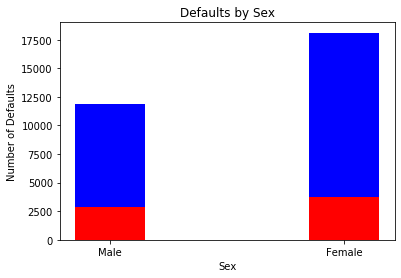

In [14]:
p1 = plt.bar(['Male', 'Female'],[df.default.loc[df['sex'] == 1].value_counts()[1], df.default.loc[df['sex'] == 2].value_counts()[1]], color='r', width=0.3)
p2 = plt.bar(['Male', 'Female'],[df.default.loc[df['sex'] == 1].value_counts()[0], df.default.loc[df['sex'] == 2].value_counts()[0]], color='b', 
             bottom=[df.default.loc[df['sex'] == 1].value_counts()[1], df.default.loc[df['sex'] == 2].value_counts()[1]], width=.3)
plt.title("Defaults by Sex")
plt.ylabel('Number of Defaults')
plt.xlabel('Sex')
plt.show()